$\large
\textbf{1. Derivation of } p(\theta \mid \tau, x):
$

$\large
\begin{align*}
p(\theta \mid \tau, x) & \propto p(x \mid \theta, \tau) \cdot p(\theta) \\
& \propto \prod_{i=1}^n \sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau}{2} (x_i - \theta)^2} \cdot \sqrt{\frac{1}{2\pi\tau_0^2}} e^{-\frac{1}{2\tau_0^2} (\theta - \theta_0)^2} \\
& \propto e^{-\frac{\tau}{2} \sum_{i=1}^n (x_i^2 - 2x_i\theta + \theta^2) - \frac{1}{2\tau_0^2} (\theta^2 - 2\theta\theta_0 + \theta_0^2)} \\
& \propto e^{-\frac{1}{2} \left(\tau n + \frac{1}{\tau_0^2}\right) \theta^2 + \left(\tau \sum_{i=1}^n x_i + \frac{\theta_0}{\tau_0^2}\right) \theta} \\
& = e^{-\frac{1}{2\sigma_\theta^2} (\theta - \mu_\theta)^2} \\
\textrm{So} & \;\;\; \theta \mid \tau, x \sim N\left(\mu_\theta, \sigma_\theta^2\right), \\
\text{where} & \;\;\; \mu_\theta = \frac{\tau n \bar{x} + \frac{\theta_0}{\tau_0^2}}{\tau n + \frac{1}{\tau_0^2}}, \quad \sigma_\theta^2 = \frac{1}{\tau n + \frac{1}{\tau_0^2}}.
\end{align*}
$

$\large
\textbf{2. Derivation of } p(\tau \mid \theta, x):
$

$\large
\begin{align*}
p(\tau \mid \theta, x) & \propto p(x \mid \theta, \tau) \cdot p(\tau) \\
& \propto \tau^{n/2} e^{-\frac{\tau}{2} \sum_{i=1}^n (x_i - \theta)^2} \cdot \tau^{\alpha - 1} e^{-\lambda \tau} \\
& \propto \tau^{\alpha + n/2 - 1} e^{-\tau \left(\lambda + \frac{1}{2} \sum_{i=1}^n (x_i - \theta)^2\right)} \\
& \propto \tau^{\alpha_\tau - 1} e^{-\beta_\tau \tau} \\
\textrm{So} & \;\;\; \tau \mid \theta, x \sim \text{Gamma}(\alpha_\tau, \beta_\tau), \\
\text{where} & \;\;\; \alpha_\tau = \alpha + \frac{n}{2}, \quad \beta_\tau = \lambda + \frac{1}{2} \sum_{i=1}^n (x_i- \theta)^2.
\end{align*}
$

$


The parameters alpha and lambda control the influence of the prior distribution on the posterior. The shape parameter alpha determines the strength of the prior belief about tau, where alpha minus one can be interpreted as the "number of pseudo-observations" contributed by the prior. A larger alpha places greater weight on the prior, making it more influential in the posterior. The rate parameter lambda affects the scale of the prior, favoring smaller values of tau (higher variance in the data) when lambda is large. Together, alpha and lambda represent the prior's strength and confidence in tau. When the sample size is small, the prior contributes significantly to the posterior, acting as a meaningful source of information. However, as the sample size increases, the likelihood dominates, reducing the relative weight of the prior. This interplay ensures the posterior reflects both the prior knowledge and the evidence provided by the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma

# Parameters for data
n = 30
m = 0  # Mean
s = 1  # Standard deviation
x = norm(loc=m, scale=s).rvs(size=n)  # Generate data

# Prior hyperparameters
theta_0 = 1.0  # Mean of prior for theta
tau_0 = 2.0    # Std dev of prior for theta
alpha = 2.0    # Shape parameter for Gamma prior on tau
lambd = 1.0    # Rate parameter for Gamma prior on tau

# Gibbs sampler settings
C = 2       # Number of chains
G = 100     # Number of Gibbs samples
theta = np.zeros((C, G))  # Storage for theta samples
tau = np.zeros((C, G))    # Storage for tau samples


In [2]:
# Initialization
theta[:, 0] = 1000  # Initial guess for theta
tau[:, 0] = 0.1     # Initial guess for tau

# Gibbs Sampling
for c in range(C):  # Loop over chains
    for g in range(1, G):  # Loop over samples
        # Sample theta | tau, x from a Normal distribution
        mean_theta = (np.mean(x) * tau[c, g-1] * n + theta_0 / tau_0**2) / (tau[c, g-1] * n + 1 / tau_0**2)
        var_theta = 1 / (tau[c, g-1] * n + 1 / tau_0**2)
        theta[c, g] = norm(loc=mean_theta, scale=np.sqrt(var_theta)).rvs()
        
        # Sample tau | theta, x from a Gamma distribution
        alpha_tau = alpha + n / 2
        beta_tau = lambd + np.sum((x - theta[c, g])**2) / 2
        tau[c, g] = gamma(a=alpha_tau, scale=1 / beta_tau).rvs()

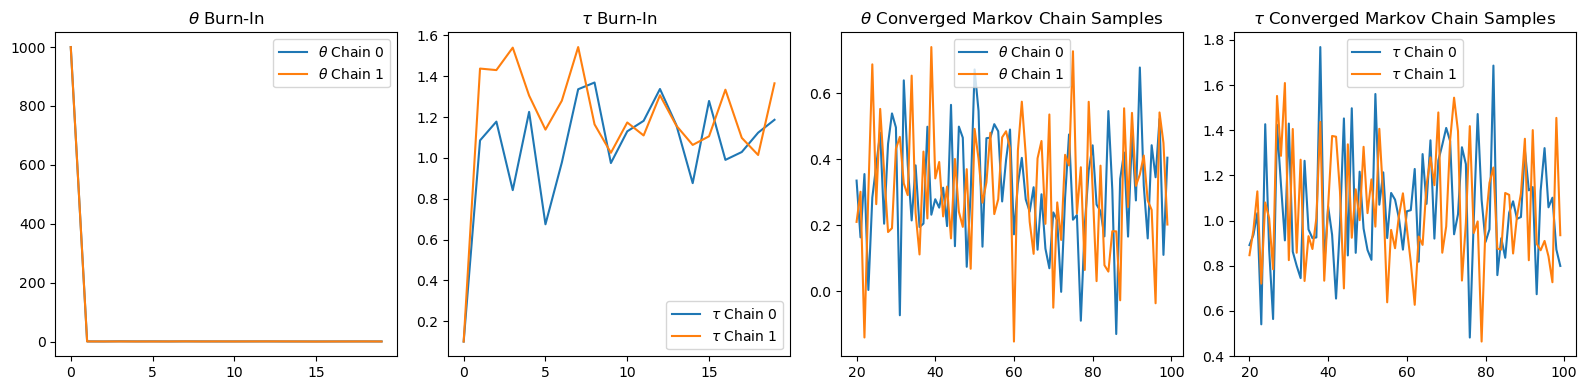

In [3]:
# Visualization
burn = 20  # Burn-in period
demo = 100  # Number of samples to demonstrate convergence

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].set_title("$\\theta$ Burn-In")
ax[1].set_title("$\\tau$ Burn-In")
ax[2].set_title("$\\theta$ Converged Markov Chain Samples")
ax[3].set_title("$\\tau$ Converged Markov Chain Samples")

for c in range(C):
    # Burn-in period
    ax[0].plot(theta[c, :burn], label=f"$\\theta$ Chain {c}")
    ax[1].plot(tau[c, :burn], label=f"$\\tau$ Chain {c}")
    
    # Stationary (converged) samples
    ax[2].plot(np.arange(burn, G), theta[c, burn:], label=f"$\\theta$ Chain {c}")
    ax[3].plot(np.arange(burn, G), tau[c, burn:], label=f"$\\tau$ Chain {c}")

for a in ax:
    a.legend()

plt.tight_layout()
plt.show()

In [4]:
# Calculate credible intervals for theta and tau after burn-in
theta_samples = theta[:, burn:].flatten()  # Flatten samples after burn-in
tau_samples = tau[:, burn:].flatten()

credible_level = 0.95  # 95% credible interval

# Credible interval for theta
theta_lower = np.percentile(theta_samples, (1 - credible_level) / 2 * 100)
theta_upper = np.percentile(theta_samples, (1 + credible_level) / 2 * 100)

# Credible interval for tau
tau_lower = np.percentile(tau_samples, (1 - credible_level) / 2 * 100)
tau_upper = np.percentile(tau_samples, (1 + credible_level) / 2 * 100)

print(f"Credible Interval for θ (Theta): ({theta_lower}, {theta_upper})")
print(f"Credible Interval for τ (Tau): ({tau_lower}, {tau_upper})")

Credible Interval for θ (Theta): (-0.07263283904445676, 0.6726710589531133)
Credible Interval for τ (Tau): (0.625341110185596, 1.551891076305011)
